In [153]:
# install.packages('caret')

In [163]:
library(caret)
library(dplyr)
library(forcats)
library(ggplot2)
library(KMsurv)
library(skimr)
library(survminer)
library(survival)
library(tidyr)
library(visdat)
library(vcd)

### I. Data Preprocessing

In [63]:
data <- read.table('hcc-survival/hcc-data.txt', sep=',')

In [64]:
colnames(data) <- scan('hcc-survival/hcc-names.txt', what=character(), sep='\n')

In [65]:
names(data) %<>% stringr::str_replace_all("\\s","_") %>% tolower

Let the target variable be 1 if the person died, and 0 otherwise.

In [66]:
data$class <- ifelse(data$class == 1, 0, 1)

In [67]:
data[data == "?"] <- NA

In [68]:
head(data)

gender,symptoms,alcohol,hepatitis_b_surface_antigen,hepatitis_b_e_antigen,hepatitis_b_core_antibody,hepatitis_c_virus_antibody,cirrhosis,endemic_countries,smoking,⋯,alkaline_phosphatase,total_proteins,creatinine,number_of_nodules,major_dimension_of_nodule,direct_bilirubin,iron,oxygen_saturation,ferritin,class
1,0,1,0,0,0,0,1,0,1,⋯,150,7.1,0.7,1,3.5,0.5,NA,NA,NA,0
0,NA,0,0,0,0,1,1,NA,NA,⋯,NA,NA,NA,1,1.8,NA,NA,NA,NA,0
1,0,1,1,0,1,0,1,0,1,⋯,109,7,2.1,5,13,0.1,28,6,16,0
1,1,1,0,0,0,0,1,0,1,⋯,174,8.1,1.11,2,15.7,0.2,NA,NA,NA,1
1,1,1,1,0,1,0,1,0,1,⋯,109,6.9,1.8,1,9,NA,59,15,22,0
1,0,1,0,NA,0,0,1,0,NA,⋯,396,5.6,0.9,1,10,1.4,53,22,111,1


Manually :( set appropriate column types.

In [69]:
nominal_features <- c('gender', 'symptoms', 'alcohol', 'hepatitis_b_surface_antigen', 'hepatitis_b_e_antigen', 
                      'hepatitis_b_core_antibody', 'hepatitis_c_virus_antibody', 'cirrhosis', 'endemic_countries',
                      'smoking', 'diabetes', 'obesity', 'hemochromatosis', 'arterial_hypertension', 
                      'chronic_renal_insufficiency', 'human_immunodeficiency_virus', 'nonalcoholic_steatohepatitis',
                      'esophageal_varices', 'splenomegaly', 'portal_hypertension', 'portal_vein_thrombosis', 
                      'liver_metastasis', 'radiological_hallmark', 'class')

numeric_features <- c('grams_of_alcohol_per_day', 'packs_of_cigarets_per_year', 'international_normalised_ratio', 
                      'alpha_fetoprotein', 'haemoglobin', 'mean_corpuscular_volume', 'leukocytes', 'platelets', 
                      'albumin', 'total_bilirubin', 'alanine_transaminase', 'aspartate_transaminase', 
                      'gamma_glutamyl_transferase', 'alkaline_phosphatase', 'total_proteins', 'creatinine', 
                      'major_dimension_of_nodule', 'direct_bilirubin', 'iron', 'oxygen_saturation', 'ferritin')

In [70]:
data[nominal_features] <- lapply(data[nominal_features], factor)

In [71]:
data[numeric_features] <- lapply(data[numeric_features], as.numeric)

In [72]:
data[c('age_at_diagnosis', 'number_of_nodules')] <- lapply(data[c('age_at_diagnosis', 'number_of_nodules')],
                                                           as.integer)

In [73]:
# ordinal features (categorical variables that have a natural ordering)
data$performance_status <- factor(data$performance_status, order=T, levels=c(0, 1, 2, 3, 4))
data$encefalopathy <- factor(data$encefalopathy, order=T, levels=c(1, 2, 3))
data$ascites_degree <- factor(data$ascites_degree, order=T, levels=c(1, 2, 3))

In [74]:
options(repr.plot.width=7, repr.plot.height=8, repr.plot.pointsize=6)

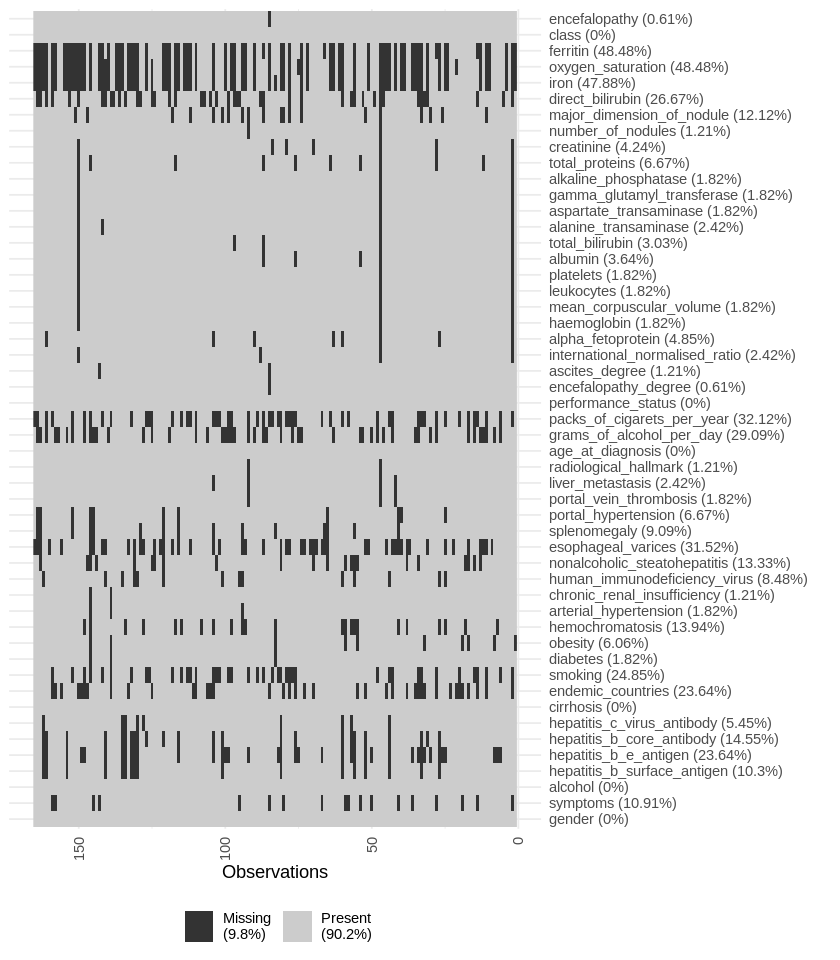

In [75]:
vis_miss(data) + ggpubr::rotate_x_text() + coord_flip()

Remove features with ~25 and more % of missing values and duplicates.

In [76]:
features_to_remove <- c('ferritin', 'iron', 'direct_bilirubin', 'oxygen_saturation', 
                        'grams_of_alcohol_per_day', 'esophageal_varices', 'endemic_countries', 
                        'hepatitis_b_e_antigen', 'smoking', 'packs_of_cigarets_per_year', 'encefalopathy_degree')

In [77]:
data <- data[, !(colnames(data) %in% features_to_remove)]

Remove some patients (4) with a large number (>10) of missing features.

In [78]:
rowSums(is.na(data))

[1]  1 15  0  0  0  0  1  1  0  0  1  1  1  1  1  0  2  2  2  0  0  0  0  0  3
 [26]  1  5  3  0  1  1  1  3  1  0  1  0  2  0  1  4  2  0  4  0  0 19  0  0  1
 [51]  0  3  0  3  3  6  4  1  4  6  0  0  1  1  3  1  1  0  0  2  0  0  0  1  0
 [76]  3  0  1  1  2  5  0  4  1  3  0  4  1  0  1  0  5  1  5  2  0  1  1  1  0
[101]  4  0  1  6  0  0  0  1  0  0  0  1  0  0  1  3  2  1  0  0  5  0  0  1  1
[126]  0  1  2  1  4  4  2  0  4  4  0  0  0  4  0  3  1  2  1  3  9  2  1  0 13
[151]  1  2  0  2  0  0  0  1  1  0  3  4  3  2  0

In [79]:
data <- data[!apply(data, 1, function(x) sum(is.na(x)) >= 10),]
rownames(data) <- NULL

Fill some missing values by mode and mean.

In [80]:
mode <- function(x) {
    ux <- unique(x)
    ux[which.max(tabulate(match(x, ux)))]
}

data <- replace_na(data=data,
                   replace=list(arterial_hypertension = mode(data$arterial_hypertension),
                                ascites_degree = mode(data$ascites_degree),
                                chronic_renal_insufficiency = mode(data$chronic_renal_insufficiency), 
                                diabetes = mode(data$diabetes),
                                encefalopathy = mode(data$encefalopathy), 
                                liver_metastasis = mode(data$liver_metastasis), 
                                hepatitis_c_virus_antibody = mode(data$hepatitis_c_virus_antibody), 
                                portal_vein_thrombosis = mode(data$portal_vein_thrombosis), 
                                radiological_hallmark = mode(data$radiological_hallmark), 
                                number_of_nodules = mode(data$number_of_nodules), 
                                alanine_transaminase = round(mean(data$alanine_transaminase, na.rm=T)), 
                                albumin = round(mean(data$albumin, na.rm=T)), 
                                alpha_fetoprotein = mean(data$alpha_fetoprotein, na.rm=T), 
                                creatinine = round(mean(data$creatinine, na.rm=T)),
                                international_normalised_ratio = round(mean(data$international_normalised_ratio, na.rm=T)), 
                                total_bilirubin = round(mean(data$total_bilirubin, na.rm=T)),
                                total_proteins = round(mean(data$total_proteins, na.rm=T))))

In [81]:
values <- data$major_dimension_of_nodule
indices <- which(is.na(values))
data$major_dimension_of_nodule[indices] <- runif(length(indices), min = min(values, na.rm=T),
                                                 max = max(values, na.rm=T))

In [57]:
skim_to_list(data)

variable,missing,complete,n,n_unique,top_counts,ordered
alcohol,0,162,162,2,"1: 122, 0: 40, NA: 0",FALSE
arterial_hypertension,0,162,162,2,"0: 104, 1: 58, ?: 0, NA: 0",FALSE
ascites_degree,0,162,162,3,"1: 108, 2: 36, 3: 18, NA: 0",TRUE
chronic_renal_insufficiency,0,162,162,2,"0: 142, 1: 20, ?: 0, NA: 0",FALSE
cirrhosis,0,162,162,2,"1: 148, 0: 14, NA: 0",FALSE
class,0,162,162,2,"0: 99, 1: 63, NA: 0",FALSE
diabetes,0,162,162,2,"0: 107, 1: 55, ?: 0, NA: 0",FALSE
encefalopathy,0,162,162,3,"1: 140, 2: 18, 3: 4, NA: 0",TRUE
gender,0,162,162,2,"1: 133, 0: 29, NA: 0",FALSE
hemochromatosis,23,139,162,2,"0: 132, NA: 23, 1: 7, ?: 0",FALSE


Replace NaN in some columns with other values, keeping proportions.

In [129]:
split_na <- function(x) {
    values <- table(x)
    rownames(values) <- NULL

    indices <- which(is.na(x))
    p <- round(values[2] / sum(values), 2)
    x[indices] <- sample(c('0', '1'), length(indices), replace = T, prob = c(1 - p, p))
    return(x)
}

with_na <- c('hemochromatosis', 'hepatitis_b_core_antibody', 'hepatitis_b_surface_antigen', 
             'human_immunodeficiency_virus', 'nonalcoholic_steatohepatitis', 'obesity', 'portal_hypertension', 
             'splenomegaly', 'symptoms')

data[with_na] <- apply(data[with_na], 2, split_na)
data[with_na] <- lapply(data[with_na], factor)

### II. Survival function

In [175]:
surv.object <- Surv(rep(-Inf, nrow(data)), data$age_at_diagnosis + 1, as.numeric(data$class))
surv.fit <- survfit(surv.object ~ 1, conf.type='log-log')
summary(surv.fit)

Call: survfit(formula = surv.object ~ 1, conf.type = "log-log")

 time n.risk n.event censored survival std.err lower 95% CI upper 95% CI
   28    160       1        2   0.9938 0.00623      0.95647        0.999
   41    157       1        3   0.9874 0.00884      0.95064        0.997
   42    155       1        1   0.9810 0.01084      0.94240        0.994
   44    153       1        1   0.9746 0.01252      0.93383        0.990
   45    151       1        0   0.9682 0.01400      0.92524        0.987
   46    150       1        0   0.9617 0.01533      0.91679        0.983
   50    147       2        2   0.9486 0.01769      0.89991        0.974
   52    142       2        5   0.9353 0.01980      0.88302        0.965
   53    138       2        3   0.9217 0.02171      0.86622        0.955
   57    130       1        7   0.9146 0.02267      0.85743        0.950
   58    125       1        2   0.9073 0.02364      0.84837        0.944
   60    119       1        5   0.8997 0.02464      0.83891

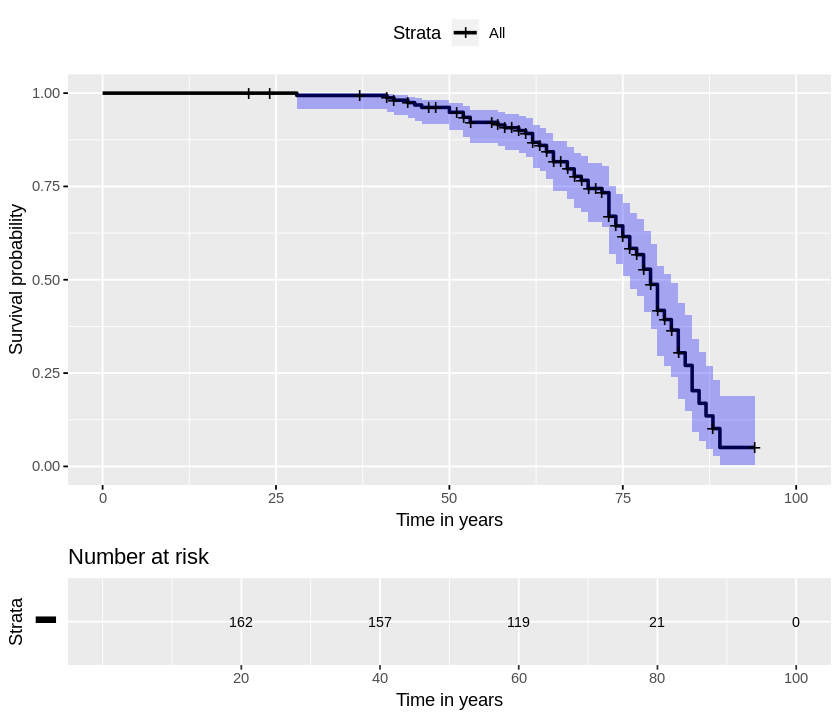

In [176]:
ggsurvplot(surv.fit, 
           data=data, 
           risk.table=T,
           conf.int=T,
           conf.int.fill="blue",
           palette="black",
           xlab='Time in years',
           ggtheme=theme_gray(),
           risk.table.y.text.col=T,
           risk.table.y.text=F,
           fontsize=3
          )

Take a look at main features.

In [133]:
options(repr.plot.width=7, repr.plot.height=6, repr.plot.pointsize=6)

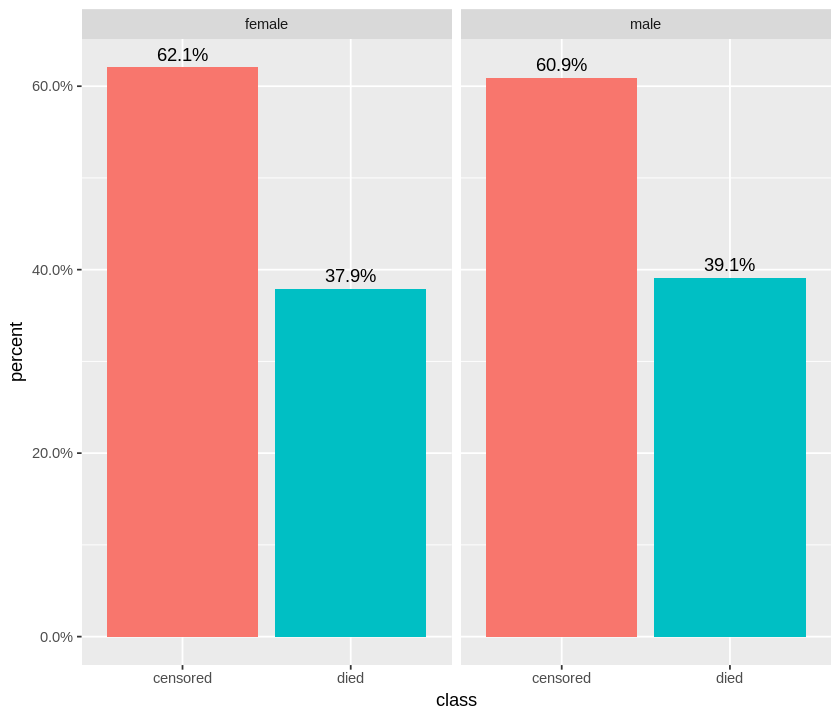

In [134]:
gender.labs <- c("female", "male")
names(gender.labs) <- c(0, 1)

ggplot(data, aes(x=class,  group=gender)) + 
    geom_bar(aes(y=..prop.., fill=factor(..x..)), stat="count") +
    geom_text(aes(label=scales::percent(..prop..), y=..prop..), stat="count", vjust=-.5) +
    labs(x="class", y="percent", fill="class") +
    facet_grid(~gender, labeller=labeller(gender=gender.labs)) +
    scale_y_continuous(labels=scales::percent) +
    guides(fill=F) +
    scale_x_discrete(labels=c("0"="censored", "1"="died"))

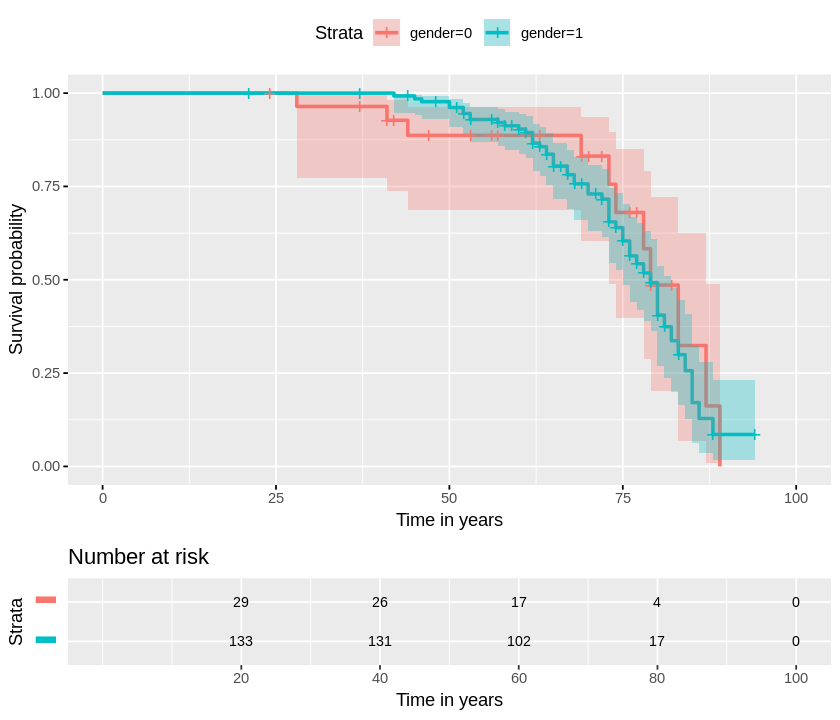

In [182]:
ggsurvplot(survfit(surv.object ~ data$gender, conf.type='log-log'), 
           data=data,
           risk.table=T,
           conf.int=T,
           xlab='Time in years',
           
           ggtheme=theme_gray(),
           risk.table.y.text.col=T,
           risk.table.y.text=F,
           fontsize=3
          )

### III. Cox Regression

In [136]:
features <- colnames(data[, !(colnames(data) %in% c('age_at_diagnosis', 'class'))])

In [143]:
set.seed(666)
indices <- sample(length(features), 19, replace=F)

In [144]:
formula1 <- as.formula(paste("surv.object ~", paste(features[indices], collapse=" + ")))
formula2 <- as.formula(paste("surv.object ~", paste(features[-indices], collapse=" + ")))

In [156]:
formula <- as.formula(paste("surv.object ~", paste(features[sample(length(features), 10)], collapse=" + ")))

In [158]:
summary(coxph(formula1, data=data))

Call:
coxph(formula = formula1, data = data)

  n= 162, number of events= 63 

                                    coef exp(coef)  se(coef)      z Pr(>|z|)
alpha_fetoprotein              -0.004988  0.995024  0.004528 -1.102   0.2706
liver_metastasis1               0.453439  1.573715  0.391054  1.160   0.2462
number_of_nodules              -0.031149  0.969331  0.103220 -0.302   0.7628
hepatitis_c_virus_antibody1     1.827125  6.215988  0.400564  4.561 5.08e-06
splenomegaly1                   0.556964  1.745366  0.364423  1.528   0.1264
encefalopathy.L                 0.837929  2.311575  0.492995  1.700   0.0892
encefalopathy.Q                 0.674443  1.962939  0.477716  1.412   0.1580
radiological_hallmark1          0.292709  1.340053  0.327604  0.893   0.3716
hemochromatosis1                0.880227  2.411447  0.625867  1.406   0.1596
nonalcoholic_steatohepatitis1  -0.330980  0.718219  0.709584 -0.466   0.6409
international_normalised_ratio  0.015556  1.015677  0.007785  1.998   0.04

In [159]:
summary(coxph(formula2, data=data))

Call:
coxph(formula = formula2, data = data)

  n= 162, number of events= 63 

                                    coef  exp(coef)   se(coef)      z Pr(>|z|)
symptoms1                      0.6346040  1.8862750  0.3608787  1.758   0.0787
hepatitis_b_surface_antigen1   0.0496534  1.0509068  0.5633612  0.088   0.9298
hepatitis_b_core_antibody1     0.3123356  1.3666133  0.3968745  0.787   0.4313
diabetes1                      0.2499485  1.2839592  0.3603984  0.694   0.4880
arterial_hypertension1        -0.8479325  0.4282995  0.3815141 -2.223   0.0262
chronic_renal_insufficiency1  -0.1974637  0.8208099  0.4806601 -0.411   0.6812
human_immunodeficiency_virus1  1.3378432  3.8108154  0.9080497  1.473   0.1407
portal_vein_thrombosis1        0.6063250  1.8336803  0.3613697  1.678   0.0934
performance_status.L           0.4235475  1.5273704  0.3979202  1.064   0.2871
performance_status.Q           0.6291062  1.8759331  0.3926978  1.602   0.1092
performance_status.C           0.2190646  1.2449117 

The final model (includes important variables only).

In [160]:
coxph.fit <- coxph(surv.object ~ hepatitis_c_virus_antibody + encefalopathy + international_normalised_ratio +
                   portal_hypertension + creatinine + ascites_degree + symptoms + arterial_hypertension +
                   portal_vein_thrombosis, data=data)
summary(coxph.fit)

Call:
coxph(formula = surv.object ~ hepatitis_c_virus_antibody + encefalopathy + 
    international_normalised_ratio + portal_hypertension + creatinine + 
    ascites_degree + symptoms + arterial_hypertension + portal_vein_thrombosis, 
    data = data)

  n= 162, number of events= 63 

                                    coef exp(coef)  se(coef)      z Pr(>|z|)
hepatitis_c_virus_antibody1     1.770002  5.870863  0.348309  5.082 3.74e-07
encefalopathy.L                 0.878421  2.407095  0.487332  1.803 0.071465
encefalopathy.Q                 1.074896  2.929687  0.464217  2.316 0.020585
international_normalised_ratio  0.024861  1.025173  0.007540  3.297 0.000976
portal_hypertension1           -1.091482  0.335718  0.395907 -2.757 0.005835
creatinine                     -0.015920  0.984206  0.007562 -2.105 0.035264
ascites_degree.L               -0.118705  0.888070  0.323299 -0.367 0.713494
ascites_degree.Q               -0.618565  0.538717  0.276582 -2.236 0.025322
symptoms1           